In [1]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt

#visits = [181898, 182014, 193861, 219976, 405724, 417009, 417057, 436500, 452564, 452599, 456722]
visits = [219976, 405724, 417009, 436500, 452564, 452599, 456722]
filt = 'r'

bigCat = Table.read('src_catalog_2.fits')

In [1]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt

visits = [219976, 405724, 417009, 436500, 452564, 452599, 456722]
#visits = [219976, 405724]
#tracts = [4429,  4431,  4433,  4637,  4639,  4848,  4850,  4852,  5063,  5065,
#          4430,  4432,  4636,  4638,  4640,  4849,  4851,  5062,  5064,  5066]

#Fix the track number for the moment
tract = 4429
filt = 'r'
butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run1.1-test2/w_2018_14/work/0/output")

fluxType = "base_PsfFlux"
#fluxType = "base_CircularApertureFlux_6_0"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssCentroid_flag_almostNoSecondDerivative", "base_SdssCentroid_flag_edge", "base_SdssCentroid_flag_noSecondDerivative",
         "base_SdssCentroid_flag_notAtMaximum", "base_SdssCentroid_flag_resetToPeak", 
         "base_SdssShape_flag", "base_ClassificationExtendedness_flag"]

In [9]:
catList = []
for visit in visits:
    print('Reading visit:', visit)
    for count,data_ref in enumerate(butler.subset('src', visit=visit)):
        if data_ref.datasetExists():
            dataId = data_ref.dataId
        else:
            continue
        dataId['tract'] = tract
        if butler.datasetExists('jointcal_wcs', dataId) == False:
            continue
        if count%10 == 0 :
            print(count, dataId)
        src = butler.get('src', dataId, immediate=True, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
        v = src.asAstropy()

        # select sources
        cut = np.ones_like(v['id'], dtype=bool)
        for flag in Flags:
            cut &= v[flag]==False
        cut &= (v[fluxType + '_flux'] > 0) & (v[fluxType + '_flux'] / v[fluxType + '_fluxSigma'] > 5)
        cut &= v['base_ClassificationExtendedness_value'] < 0.5

        # get calibration object and then magnitudes with errors
        calib = butler.get("calexp_calib", dataId, immediate=True)
        mag, magErr = calib.getMagnitude(v[cut][fluxType + '_flux'], v[cut][fluxType + '_fluxSigma'])

        cat = v[cut]['id', 'coord_ra', 'coord_dec']
        cat['mag'] = mag
        cat['magErr'] = magErr

        # add dataId info
        for k in dataId.keys():
            cat[k] = dataId[k]
            
        # Get WCS info from calexp_wcs and from jointcal_wcs
        oldWcs = butler.get("calexp_wcs", dataId, immediate=True)
        newWcs = butler.get('jointcal_wcs', dataId, immediate=True)
        newRa = []
        newDec = []
        pixels = oldWcs.skyToPixel([afwGeom.SpherePoint(ra, dec, afwGeom.radians) for ra, dec in zip(cat['coord_ra'], cat['coord_dec'])])
        newCoord = newWcs.pixelToSky(pixels)
#        for c in cat:
#            pixels = oldWcs.skyToPixel(afwGeom.SpherePoint(c['coord_ra'], c['coord_dec'], afwGeom.radians))
#            newRa.append(float((newWcs.pixelToSky(pixels).getRa())))
#            newDec.append(float((newWcs.pixelToSky(pixels).getDec())))
        cat['newRa'] = [float(cd.getRa()) for cd in newCoord]
        cat['newDec'] = [float(cd.getDec()) for cd in newCoord]
        cat['newRa'].unit = units.rad
        cat['newDec'].unit = units.rad

        # hack to get rid of a warning related to a merging conflict
        cat.meta['NOISE_EXPOSURE_ID'] = 0
         
        # add catalog to the list    
        catList.append(cat)
        
# merge all individual catalogs into a single big one    
bigCat = vstack(catList)


Reading visit: 219976
0 {'visit': 219976, 'filter': 'r', 'raft': '0,1', 'sensor': '0,0', 'tract': 4429}
10 {'visit': 219976, 'filter': 'r', 'raft': '2,2', 'sensor': '0,0', 'tract': 4429}
20 {'visit': 219976, 'filter': 'r', 'raft': '4,3', 'sensor': '0,0', 'tract': 4429}
30 {'visit': 219976, 'filter': 'r', 'raft': '2,1', 'sensor': '0,1', 'tract': 4429}
40 {'visit': 219976, 'filter': 'r', 'raft': '4,2', 'sensor': '0,1', 'tract': 4429}
50 {'visit': 219976, 'filter': 'r', 'raft': '2,0', 'sensor': '0,2', 'tract': 4429}
60 {'visit': 219976, 'filter': 'r', 'raft': '4,1', 'sensor': '0,2', 'tract': 4429}
70 {'visit': 219976, 'filter': 'r', 'raft': '1,4', 'sensor': '1,0', 'tract': 4429}
80 {'visit': 219976, 'filter': 'r', 'raft': '3,4', 'sensor': '1,0', 'tract': 4429}
90 {'visit': 219976, 'filter': 'r', 'raft': '1,3', 'sensor': '1,1', 'tract': 4429}
100 {'visit': 219976, 'filter': 'r', 'raft': '3,3', 'sensor': '1,1', 'tract': 4429}
110 {'visit': 219976, 'filter': 'r', 'raft': '1,2', 'sensor': '1,

In [ ]:
bigCat.write('src_catalog_2.fits')

In [10]:
bigCat

id,coord_ra,coord_dec,mag,magErr,visit,filter,raft,sensor,tract,newRa,newDec
,rad,rad,,,,,,,,rad,rad
int64,float64,float64,float64,float64,int64,str4,str12,str12,int64,float64,float64
944789809790999,1.0092536337155873,-0.5193682192489143,22.66501615410421,0.03842596147747921,219976,r,"0,1","0,0",4429,1.0092535694679325,-0.5193681766138177
944789809791000,1.0089875739231855,-0.519229209579885,23.9139977823754,0.11187889226711688,219976,r,"0,1","0,0",4429,1.0089875061742022,-0.5192291701232327
944789809791004,1.009862006175827,-0.5196857647165503,23.629812901668643,0.06283691115794031,219976,r,"0,1","0,0",4429,1.0098620576236998,-0.5196856788028168
944789809791005,1.009055420054835,-0.5192698085276213,23.405940397005985,0.07174700768796193,219976,r,"0,1","0,0",4429,1.0090553507603783,-0.5192697695362234
944789809791013,1.007780511791306,-0.5186195815479914,24.034367208440944,0.15275496747555503,219976,r,"0,1","0,0",4429,1.0077805889633507,-0.5186195407389395
944789809791015,1.0072803995410184,-0.5183604205794349,24.0132799289662,0.15745397311661574,219976,r,"0,1","0,0",4429,1.0072805421810482,-0.5183603881847049
944789809791020,1.0071466124302246,-0.5182972219547858,23.913687625683636,0.14570812273442604,219976,r,"0,1","0,0",4429,1.0071467662888798,-0.5182971930119251
944789809791025,1.0098606070113472,-0.5197087750027046,23.798465625046052,0.07168336643177874,219976,r,"0,1","0,0",4429,1.0098606585555343,-0.5197086931353387


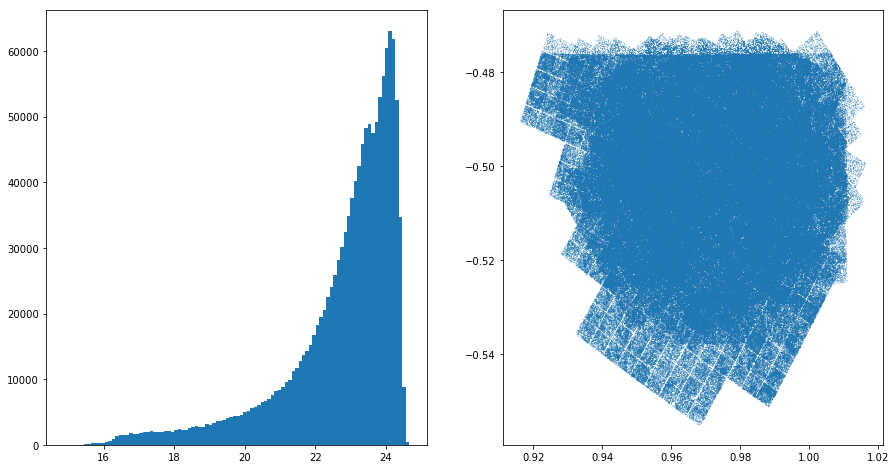

In [11]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(bigCat['mag'], bins=100)
_ = ax1.scatter(bigCat['coord_ra'], bigCat['coord_dec'], s=0.01)

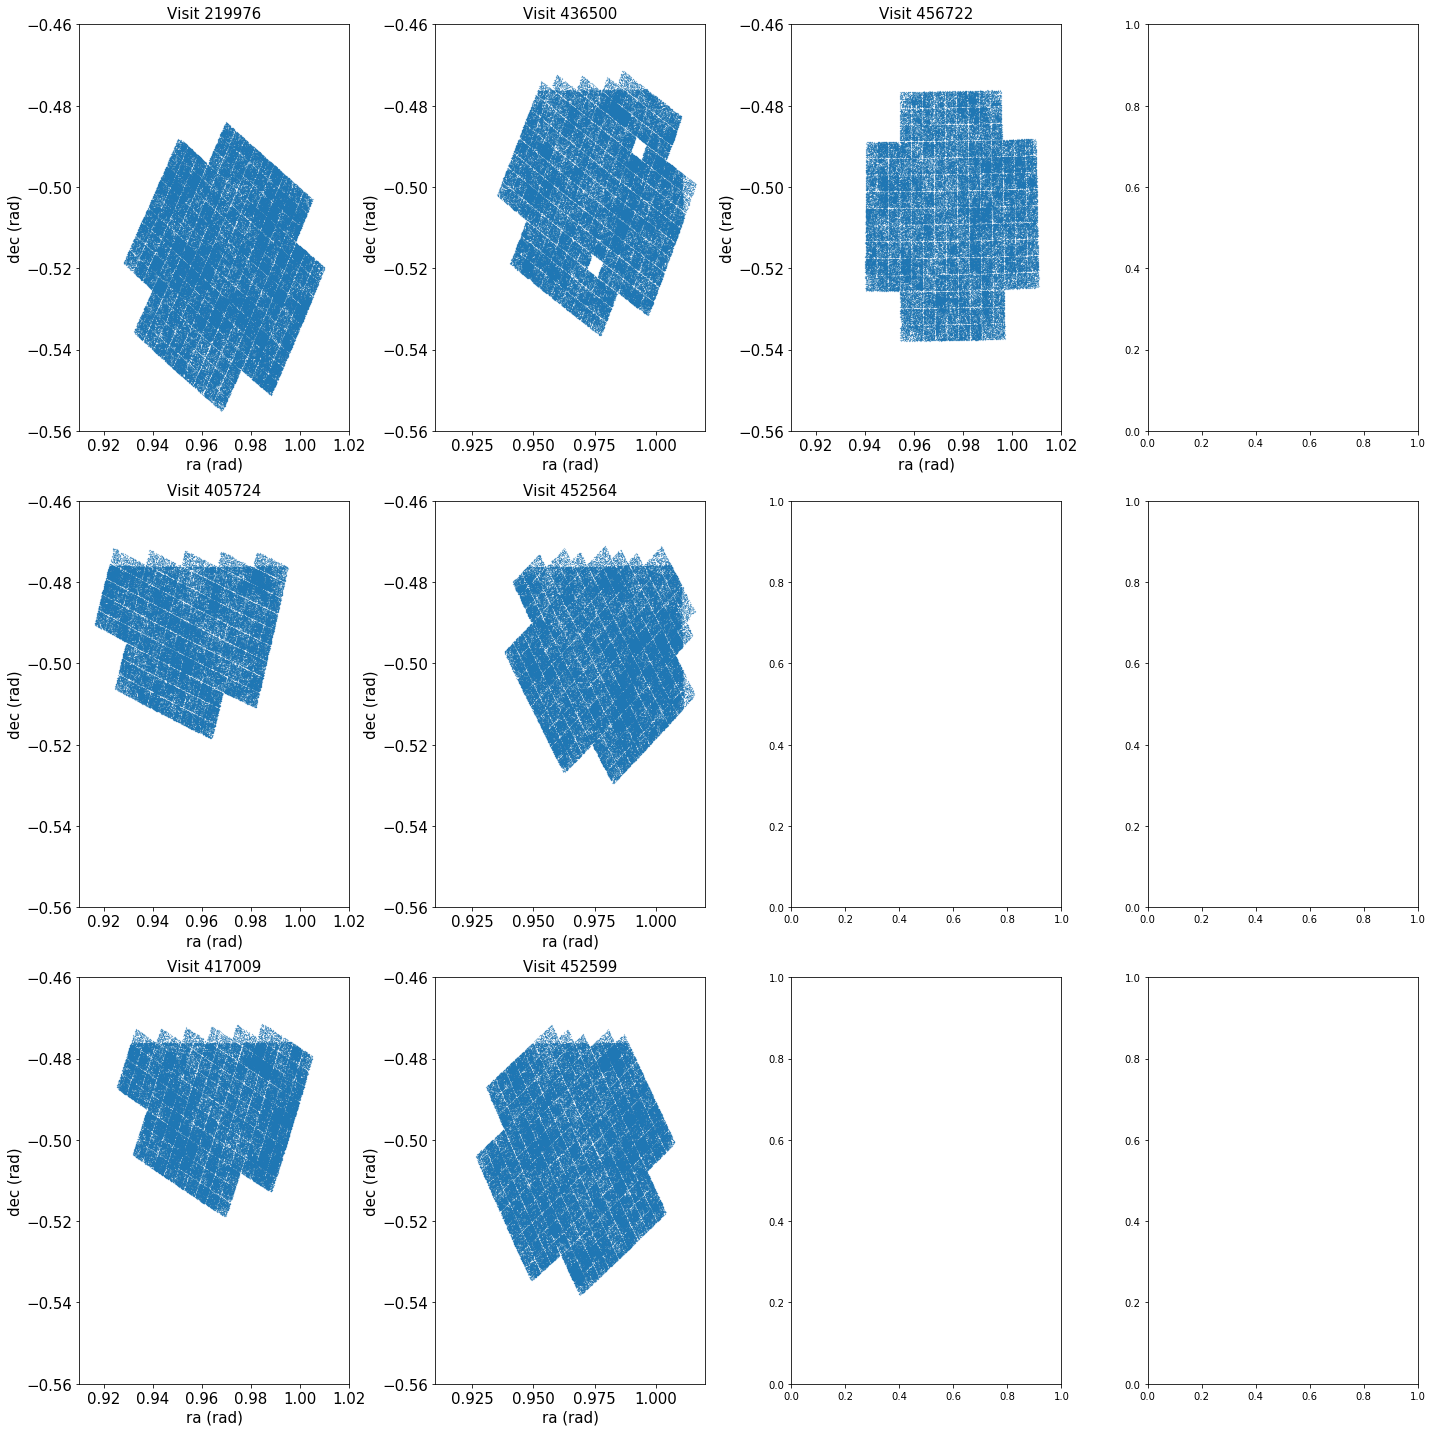

In [89]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,20))
for i,v in enumerate(visits):
    a = i%3
    b = i//3
    cut = bigCat['visit'] == v
    ax[a][b].scatter(bigCat[cut]['coord_ra'], bigCat[cut]['coord_dec'], s=0.02)
    ax[a][b].set_xlim([0.91,1.02])
    ax[a][b].set_ylim([-0.56, -0.46])
    ax[a][b].set_xlabel('ra (rad)', fontsize=15)
    ax[a][b].set_ylabel('dec (rad)', fontsize=15)
    ax[a][b].set_title('Visit %d'%(v), fontsize=15)
    ax[a][b].tick_params(labelsize=15)
    
fig.tight_layout()

In [42]:
#fig.savefig("ra_dec_r.png")

In [12]:
from astropy.coordinates import SkyCoord
from astropy import units as u

visits = [219976, 405724, 417009, 436500, 452564, 452599, 456722]
vRef = 456722
tract = 4429
cRef = SkyCoord(ra = bigCat[bigCat['visit']==vRef]['coord_ra'], dec = bigCat[bigCat['visit']==vRef]['coord_dec'])
cRefNew = SkyCoord(ra = bigCat[bigCat['visit']==vRef]['newRa'], dec = bigCat[bigCat['visit']==vRef]['newDec'])

bigCat['dist'] = 999999.

dist = []
distNew = []
for count,v in enumerate(visits):
    if v == vRef:
        dist = dist + [9999.]*sum(bigCat['visit']==vRef)
        distNew = distNew + [9999.]*sum(bigCat['visit']==vRef)
        continue
    
    c = SkyCoord(ra = bigCat[bigCat['visit']==v]['coord_ra'], dec = bigCat[bigCat['visit']==v]['coord_dec'])
    cNew = SkyCoord(ra = bigCat[bigCat['visit']==v]['newRa'], dec = bigCat[bigCat['visit']==v]['newDec'])
    idx, d2d, d3d = c.match_to_catalog_sky(cRef)
    idxNew, d2dNew, d3dNew = cNew.match_to_catalog_sky(cRefNew)
    
    dist = dist + d2d.milliarcsecond.tolist()
    distNew = distNew + d2dNew.milliarcsecond.tolist()
    
bigCat['dist'] = dist
bigCat['distNew'] = distNew

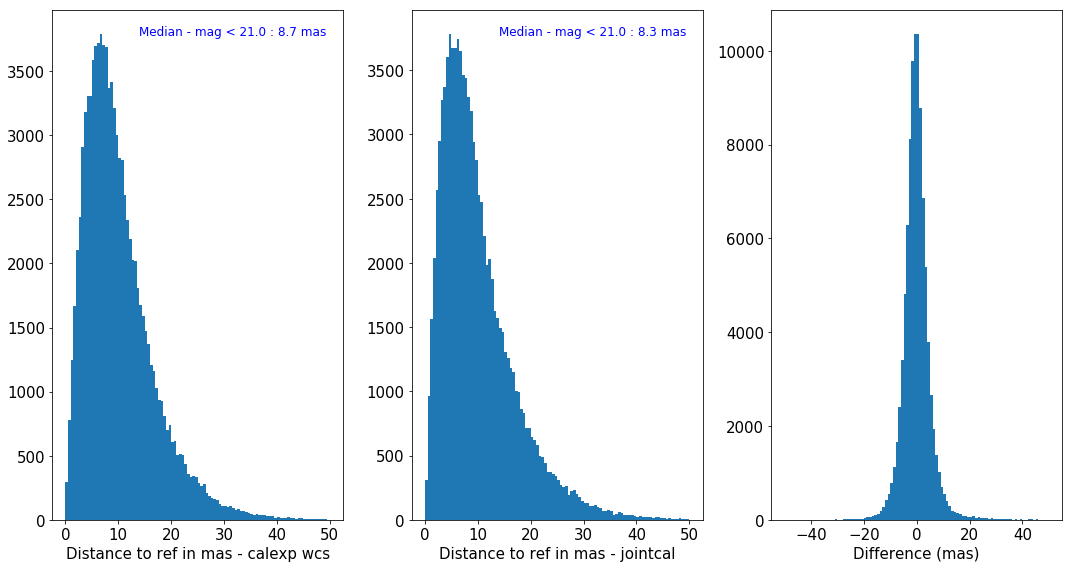

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))

magCut = 21
cut = (bigCat['dist'] < 300) & (bigCat['distNew'] < 300) & (bigCat['mag'] < magCut)
_ = ax0.hist(bigCat[cut]['dist'], bins=100, range = [0., 50])
_ = ax1.hist(bigCat[cut]['distNew'], bins=100, range = [0., 50])
_ = ax2.hist(bigCat[cut]['distNew'] - bigCat[cut]['dist'], bins=100, range=[-50, 50])

ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax0.set_xlabel('Distance to ref in mas - calexp wcs', fontsize=15)
ax1.set_xlabel('Distance to ref in mas - jointcal', fontsize=15)
ax2.set_xlabel('Difference (mas)', fontsize=15)

ax0.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['dist'])),
             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
ax1.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['distNew'])),
             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
                                                         
fig.tight_layout()

In [118]:
fig.savefig("DC2_astrometry.png")